In [18]:
import asyncio
import itertools
import logging
import random
import nest_asyncio
import pandas as pd

nest_asyncio.apply()  #

In [19]:
import torch

torch.cuda.is_available()

True

In [20]:
import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union

from nuplan.planning.script.run_simulation import main as main_simulation

In [4]:
%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
%pwd

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/


'/home/ehdykhne/nuplan-devkit/experiments'

In [21]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import (
    run_runners,
    set_default_path,
    set_up_common_builder,
)
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv("NUPLAN_HYDRA_CONFIG_PATH", "config/simulation")

if os.environ.get("NUPLAN_HYDRA_CONFIG_PATH") is not None:
    CONFIG_PATH = os.path.join("../../../../", CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != "simulation":
    CONFIG_PATH = os.path.join(CONFIG_PATH, "simulation")
CONFIG_NAME = "default_simulation"

In [6]:
# list of selected scenario tokens
from tokens import selected_scenario_tokens, modifiable_scenario_tokens

print(selected_scenario_tokens[0:3])
print(modifiable_scenario_tokens[0:3])

selected_scenario_tokens = ["8b80aa05d88b518b"]

['d6234553edc95d50', '98ddd7851e445b7a', '5ac5795b9b5851e8']
['014c7f3502d4597d', '02828821ef045829', '02fa9b8d43465e0d']


In [7]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(
    os.getenv("NUPLAN_TUTORIAL_PATH", ""), "../nuplan/planning/script"
)
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

In [22]:
left_turn_types = [
    "stopping_at_crosswalk",
    "high_lateral_acceleration",
    "near_multiple_vehicles",
    "on_stopline_stop_sign",
    "near_long_vehicle",
    "unknown",
    "near_barrier_on_driveable",
    "near_high_speed_vehicle",
]
scenario_types = [
    "starting_left_turn",
    # "accelerating_at_traffic_light_with_lead",
    # "crossed_by_bike",
    # "crossed_by_vehicle",
    # "on_intersection",
    # "on_stopline_crosswalk",
    # "on_stopline_stop_sign",
    # "on_stopline_traffic_light",
    # "on_traffic_light_intersection",
    # "starting_protected_cross_turn",
    # "starting_protected_noncross_turn",
    "starting_right_turn",
    "starting_straight_stop_sign_intersection_traversal",
    "starting_straight_traffic_light_intersection_traversal",
    # "starting_u_turn",
    "starting_unprotected_cross_turn",
    "starting_unprotected_noncross_turn",
    # "stationary_at_crosswalk",
    # "stationary_at_traffic_light_with_lead",
    # "stationary_at_traffic_light_without_lead",
    # "traversing_crosswalk",
    "traversing_intersection",
    "traversing_traffic_light_intersection",
]

left_turn_potential = [
    "starting_left_turn",
    "starting_unprotected_cross_turn",
]

# scenario_types = ['stationary_at_traffic_light_without_lead']

# selected_scenario_tokens = ["4b95591c786b5558"]  # cross bug
# selected_scenario_tokens = ["2b430abcf49554c7"]  # merge occlusion bug

experiment_name = "base_bench"

scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
DATASET_PARAMS = [
    f"scenario_builder={scenario_builder}",
    "scenario_filter=all_scenarios",  # [all_scenarios, val14_split]
    f"scenario_filter.scenario_types={scenario_types}",  # there are 70 scenario types in the trainingset and 58 in the validation set including "unknown" which make up the majority
    "scenario_filter.ego_displacement_minimum_m=10",  # use scenarios where the ego vehicle moves at least 10m
    #    'scenario_filter.remove_invalid_goals=true',  # remove scenarios where the goal is not invalid
    # "scenario_filter.ego_start_speed_threshold=5",  # Exclusive threshold that the ego's speed must rise above (meters per second) for scenario to be kept
    #    'scenario_filter.stop_speed_threshold=10',  # Inclusive threshold that the ego's speed must fall below (meters per second) for scenario to be kept:
    "scenario_filter.map_names=[sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]",  # select multiple [sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]
    # "scenario_filter.limit_total_scenarios=0.05",  # use n total scenarios if int, or if float smaller than 1, use n as a fraction of total scenarios (changes sampling frequency, unchanged leaves the frequency at 20Hz)
    "scenario_filter.num_scenarios_per_type=400",  # use 10 scenarios per scenario type #bring this back to 25 for testing the cross bug
    # f"scenario_filter.scenario_tokens={selected_scenario_tokens}",  # List of scenarios to include (token)
    #'scenario_filter.log_names=["2021.08.24.20.03.01_veh-45_01091_01622"]',  # specific scenrios to simulate
    # turn off if you are selecting scenarios manually. turn on for initial filtering (0.05 gives us 1 scenario per second)
]

In [16]:
urban_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt"
gc_pgp_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/gc_pgp_checkpoint.ckpt"
hybrid_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt"
#'/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
#'/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg_occ = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        # "model=gc_pgp_model",
        # "model.aggregator.pre_train=false",
        # "planner.ml_planner.model_config=${model}",
        # f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
        # f"planner.pdm_closed_planner.checkpoint_path={hybrid_ckpt}",
        # "+observation.model=gc_pgp_model",
        # "+observation.model.aggregator.pre_train=false",
        # "+observation.model_config=${model}",
        # f"+observation.checkpoint_path={gc_pgp_ckpt}",
        f"observation.planner_type=pdm_closed",
        # # f"observation.pdm_hybrid_ckpt={hybrid_ckpt}",
        f"observation.occlusion_cfg.occlusion=True",
        f"observation.occlusion_cfg.manager_type=wedge",
        f"+observation.occlusion_cfg.uncloak_reaction_time=1.5",
        f"+observation.occlusion_cfg.notice_threshold=1.0",
        "+modify_scenario_simulations=true",
        "+modifier_types=[diverge-conflict-with-occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right,
        # oncoming-left-turn-and-occlusion-injection, conflict-and-occlusion-injection,
        # sequential-conflict-with-occlusion-injection, cross-conflict-with-occlusion-injection
        # merge-conflict-with-occlusion-injection, diverge-conflict-with-occlusion-injection]
        "+remove_other_agents=true",
        "+occlusion=true",
        "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
        "+occlusion.uncloak_reaction_time=1.5",  # 0.1
        "+occlusion.notice_threshold=1.0",  # 0.1
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
    ],
)

output_folder_occ = cfg_occ.output_dir
print('output_folder_occ = "' + output_folder_occ + '"')


# closed mixed for simulation
# "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
# "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
# # "model=gc_pgp_model",
# # "model.aggregator.pre_train=false",
# # "planner.ml_planner.model_config=${model}",
# # f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
# # f"planner.pdm_closed_planner.checkpoint_path={hybrid_ckpt}",
# # "+observation.model=gc_pgp_model",
# # "+observation.model.aggregator.pre_train=false",
# # "+observation.model_config=${model}",
# # f"+observation.checkpoint_path={gc_pgp_ckpt}",
# f"observation.planner_type=pdm_closed",
# # # f"observation.pdm_hybrid_ckpt={hybrid_ckpt}",
# f"observation.occlusion_cfg.occlusion=true",
# f"observation.occlusion_cfg.manager_type=wedge",
# f"+observation.occlusion_cfg.uncloak_reaction_time=1.5",
# f"+observation.occlusion_cfg.notice_threshold=1.0",
# "+modify_scenario_simulations=true",
# "+modifier_types=[occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right]
# "+occlusion=true",
# "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
# "+occlusion.uncloak_reaction_time=1.0",
# "+occlusion.notice_threshold=0.1",
# "worker=ray_distributed",  # [sequential, ray_distributed]
# "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
# *DATASET_PARAMS,


# "+simulation=open_loop_boxes",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
#         "planner=log_future_planner",  # [ml_planner, pdm_hybrid_planner, gc_pgp_planner, idm_planner, log_future_planner, simple_planner]
#         "ego_controller=perfect_tracking_controller",
#         "worker=ray_distributed",  # [sequential, ray_distributed]
#         "+occlusion=true",  # [true, false]
#         "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
#         "+occlusion.uncloak_reaction_time=1.5",
#         "+occlusion.notice_threshold=1.0",
#         # "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
#         *DATASET_PARAMS,

NameError: name 'hydra' is not defined

# Now we can run with the following

In [10]:
# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg_occ)

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2024-04-10 04:41:03,162 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-04-10 04:41:03,200 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-04-10 04:41:03,980	INFO worker.py:1636 -- Started a local Ray instance.


2024-04-10 04:41:04,734 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-04-10 04:41:04,734 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2024-04-10 04:41:04,735 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-04-10 04:41:04,735 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-04-10 04:41:04,735 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.10.04.41.02

2024-04-10 04:41:04,737 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_build

Ray objects: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]
(raylet) [2024-04-10 04:41:13,958 E 3140827 3140839] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-10_04-41-03_233374_3140476 is over 95% full, available space: 642566479872; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-10 04:41:23,963 E 3140827 3140839] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-10_04-41-03_233374_3140476 is over 95% full, available space: 642559029248; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-10 04:41:33,968 E 3140827 3140839] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-10_04-41-03_233374_3140476 is over 95% full, available space: 642564599808; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-10 04:41:43,974 E 3140827 3140839] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-10_04-41-03_233374_3

2024-04-10 04:42:14,847 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:83}  Building metric engines...
2024-04-10 04:42:14,990 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:85}  Building metric engines...DONE
2024-04-10 04:42:14,990 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:89}  Building simulations from 2689 scenarios...


(raylet) [2024-04-10 04:42:23,995 E 3140827 3140839] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-10_04-41-03_233374_3140476 is over 95% full, available space: 642566291456; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-10 04:42:34,000 E 3140827 3140839] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-10_04-41-03_233374_3140476 is over 95% full, available space: 642566291456; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-10 04:42:44,005 E 3140827 3140839] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-10_04-41-03_233374_3140476 is over 95% full, available space: 642566283264; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-04-10 04:42:51,043 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:151}  Modyfing Scenarios...
1 0 are the number of cpus and gpus
2024-04-10 04:42:51,044 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:116}  Submitting 2689 tasks!


(raylet) [2024-04-10 04:42:54,010 E 3140827 3140839] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-10_04-41-03_233374_3140476 is over 95% full, available space: 642566279168; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-10 04:43:04,018 E 3140827 3140839] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-10_04-41-03_233374_3140476 is over 95% full, available space: 642558275584; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-10 04:43:14,026 E 3140827 3140839] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-10_04-41-03_233374_3140476 is over 95% full, available space: 642566238208; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-10 04:43:24,035 E 3140827 3140839] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-10_04-41-03_233374_3140476 is over 95% full, available space: 642566238208; capac

[
	'0515fc10ca0a5c10',
	'0a559c2fb46d588d',
	'25b0e5c53483588e',
	'4b72fa3bd965544f',
	'56e7d278ce1658c3',
	'5fae6b21738d55b6',
	'6d5c2860b3e656bb',
	'72039a4d54c85a03',
	'758f4fcc4d68573a',
	'813f97097203543c',
	'8bcd750101ab51fc',
	'9bec699bc10a5a07',
	'b28b1dc4b5ac5522',
	'bdd0d3d47ca650c1',
	'c2172be77f2b508e',
	'cac25430abed56f7',
	'd67806dd745f575c',
	'e72f1ff10a7758b9',
	'f3610d9738ef589b',
	'f7fa42b8716f508c',
	'f9e3ad7860e2588e'
]
2024-04-10 04:53:36,366 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:203}  Created 59 modified scenarios from 2689 scenarios, 21 of which were modifiable.
2024-04-10 04:53:36,368 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:204}  Building simulations...DONE!
2024-04-10 04:53:36,381 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:113}  Running simulation...
2024-04-10 04:53:36,381 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script

Ray objects:   0%|          | 0/59 [00:00<?, ?it/s](raylet) [2024-04-10 04:53:44,566 E 3140827 3140839] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-10_04-41-03_233374_3140476 is over 95% full, available space: 642564730880; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-10 04:53:54,574 E 3140827 3140839] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-10_04-41-03_233374_3140476 is over 95% full, available space: 642564714496; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-10 04:54:04,581 E 3140827 3140839] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-10_04-41-03_233374_3140476 is over 95% full, available space: 642564644864; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-10 04:54:14,588 E 3140827 3140839] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-10_04-41-03_233374_3140476 is 

2024-04-10 04:56:44,794 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:129}  Number of successful simulations: 59
2024-04-10 04:56:44,794 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:130}  Number of failed simulations: 0
2024-04-10 04:56:44,794 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-04-10 04:56:44,806 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.10.04.41.02/runner_report.parquet
2024-04-10 04:56:44,806 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:15:41 [HH:MM:SS]
2024-04-10 04:56:45,569 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:00 [HH:MM:SS]
2024-04-10 04:56:45,648 

# Now we set up the second running regime

In [11]:
#########################################

path = output_folder_occ + "/metrics/"
file_path_1 = path + "no_ego_at_fault_collisions.parquet"
df = pd.read_parquet(file_path_1)
df = df.loc[df["number_of_ego_collisions_with_vehicles_stat_value"] != 0]
df = df["scenario_name"]


scenario_list = df.tolist()
print(f"+scenarios_to_check={scenario_list}")

hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)
cfg_unocc = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        # "model=gc_pgp_model",
        # "model.aggregator.pre_train=false",
        # "planner.ml_planner.model_config=${model}",
        # f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
        # f"planner.pdm_closed_planner.checkpoint_path={hybrid_ckpt}",
        # "+observation.model=gc_pgp_model",
        # "+observation.model.aggregator.pre_train=false",
        # "+observation.model_config=${model}",
        # f"+observation.checkpoint_path={gc_pgp_ckpt}",
        f"observation.planner_type=pdm_closed",
        # # f"observation.pdm_hybrid_ckpt={hybrid_ckpt}",
        f"observation.occlusion_cfg.occlusion=false",
        "+modify_scenario_simulations=true",
        "+second_testing_round=true",
        f"+scenarios_to_check={scenario_list}",
        "+modifier_types=[diverge-conflict-with-occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right,
        # oncoming-left-turn-and-occlusion-injection, conflict-and-occlusion-injection,
        # sequential-conflict-with-occlusion-injection, cross-conflict-with-occlusion-injection
        # merge-conflict-with-occlusion-injection, diverge-conflict-with-occlusion-injection]
        "+remove_other_agents=true",
        "+occlusion=false",
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
    ],
)

output_folder_unocc = cfg_unocc.output_dir
print('output_folder_unocc = "' + output_folder_unocc + '"')

+scenarios_to_check_in_alternate_regime=['f3610d9738ef589b_diverge_conflict_injection_and_occlusion_injection_053522', 'c2172be77f2b508e_diverge_conflict_injection_and_occlusion_injection_253671', '0a559c2fb46d588d_diverge_conflict_injection_and_occlusion_injection_052956', 'f3610d9738ef589b_diverge_conflict_injection_and_occlusion_injection_253522', 'f3610d9738ef589b_diverge_conflict_injection_and_occlusion_injection_353522', '8bcd750101ab51fc_diverge_conflict_injection_and_occlusion_injection_053570']
output_folder_unocc = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.10.04.56.48"


## Run Second Regime

In [ ]:
main_simulation(cfg_unocc)

In [24]:
import pandas as pd
import re
import pickle

output_folder_unocc = (
    "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.10.04.56.48"
)

path_unocc = output_folder_unocc + "/metrics/"
file_path_2 = path_unocc + "no_ego_at_fault_collisions.parquet"
df = pd.read_parquet(file_path_2)
df = df.loc[
    df["number_of_ego_collisions_with_vehicles_stat_value"] == 0
]  # we know all these scenarios are ones where we crahsed in the occluded regime, so here, we are selecting all the ones where we also didnt crash in the unoccluded regime
df = df["scenario_name"]
scenario_list = df.tolist()
print(f"scenario mods to save to npsc file={scenario_list}")
base_scenario_tokens = [re.split("_", name, 1)[0] for name in scenario_list]
print(f"base scenarios={base_scenario_tokens}")

modification_list_dictionary = {}
with open(r"modifications_for_second_testing_round.pkl", "rb") as input_file:
    modifications_for_second_testing_round = pickle.load(input_file)

    for token in base_scenario_tokens:
        modification_list_dictionary[token] = []

    for full_modification_token in scenario_list:
        base_token = re.split("_", full_modification_token, 1)[0]
        for modification_object in modifications_for_second_testing_round[base_token]:
            if (
                base_token + modification_object.modifier_string
                == full_modification_token
            ):
                modification_list_dictionary[base_token].append(modification_object)
                print(base_token + modification_object.modifier_string)
                break

with open("npsc_files/" + experiment_name + ".npsc.pkl", "wb") as output_file:
    pickle.dump(modification_list_dictionary, output_file)
    pickle.dump(DATASET_PARAMS, output_file)

with open("npsc_files/" + experiment_name + ".npsc.pkl", "rb") as output_file:
    mod_list_dict = pickle.load(output_file)
    print(mod_list_dict.keys())
    data = pickle.load(output_file)
    print(data)

# print(experiment_name)

scenario mods to save to npsc file=['f3610d9738ef589b_diverge_conflict_injection_and_occlusion_injection_053522', '8bcd750101ab51fc_diverge_conflict_injection_and_occlusion_injection_053570']
base scenarios=['f3610d9738ef589b', '8bcd750101ab51fc']
f3610d9738ef589b_diverge_conflict_injection_and_occlusion_injection_053522
8bcd750101ab51fc_diverge_conflict_injection_and_occlusion_injection_053570
dict_keys(['f3610d9738ef589b', '8bcd750101ab51fc'])
['scenario_builder=val', 'scenario_filter=all_scenarios', "scenario_filter.scenario_types=['starting_left_turn', 'starting_right_turn', 'starting_straight_stop_sign_intersection_traversal', 'starting_straight_traffic_light_intersection_traversal', 'starting_unprotected_cross_turn', 'starting_unprotected_noncross_turn', 'traversing_intersection', 'traversing_traffic_light_intersection']", 'scenario_filter.ego_displacement_minimum_m=10', 'scenario_filter.map_names=[sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]', '

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
number_of_ego_collisions_with_vehicles_stat_value (top 25 differences)
positive diff
                                                                scenario_name  difference                        scenario_type_1
0  f3610d9738ef589b_diverge_conflict_injection_and_occlusion_injection_053522           1                traversing_intersection
5  8bcd750101ab51fc_diverge_conflict_injection_and_occlusion_injection_053570           1                traversing_intersection
1  c2172be77f2b508e_diverge_conflict_injection_and_occlusion_injection_253671           0                traversing_intersection
2  0a559c2fb46d588d_diverge_conflict_injection_and_occlusion_injection_052956           0  traversing_traffic_light_intersection
3  f3610d9738ef589b_diverge_conflict_injection_and_occlusion_injection_253522     

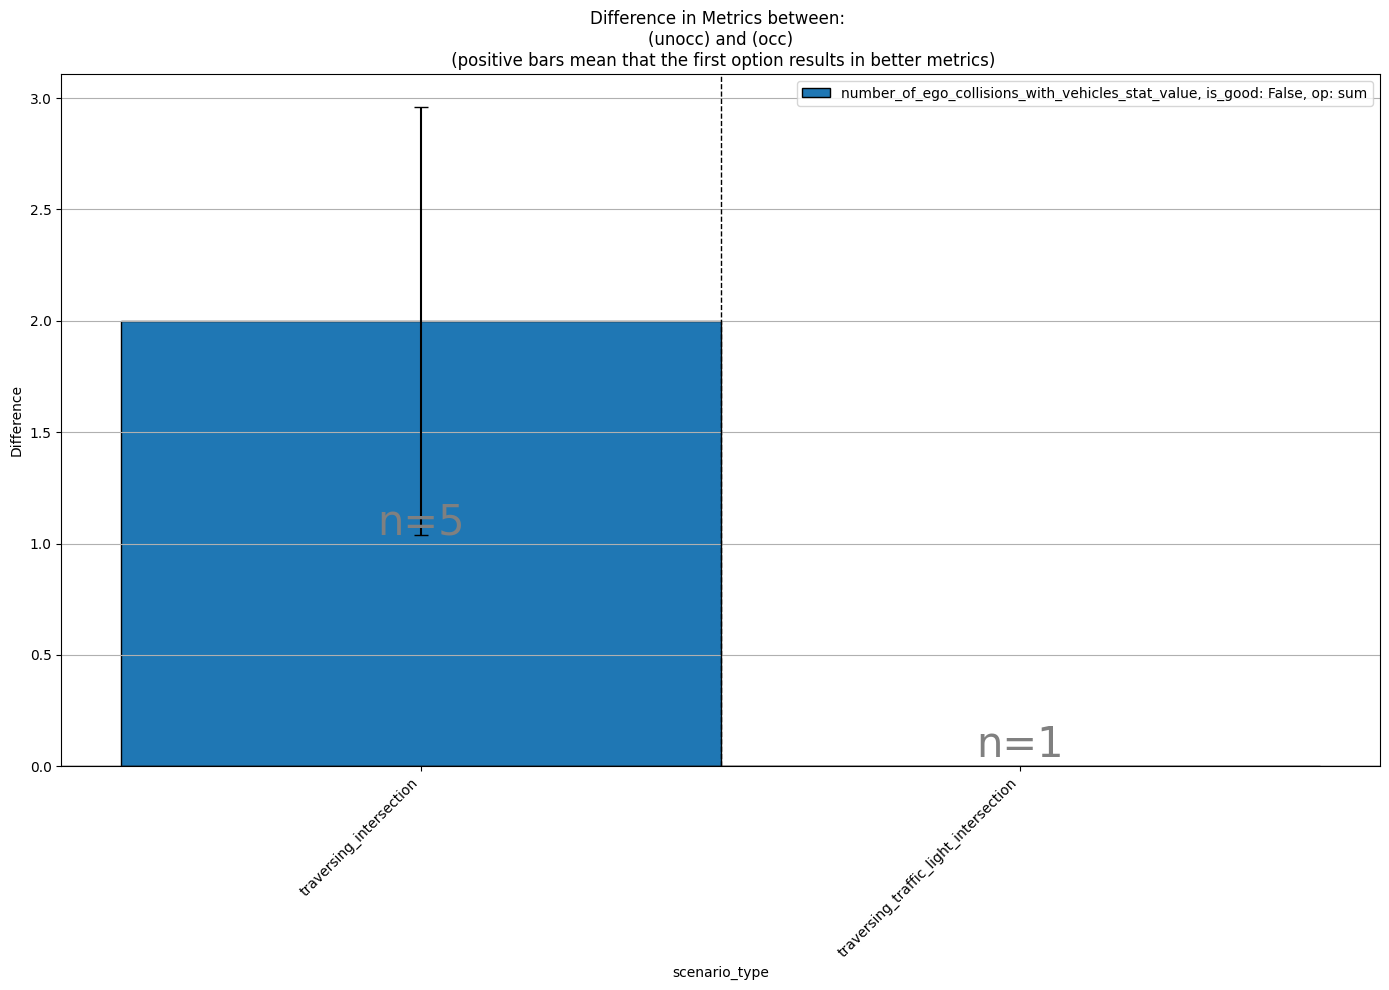

In [1]:
from vis_utils import plot_diff

# %env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
# %env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
# %env NUPLAN_EXP_ROOT=../../data/nuplan/exp
# %env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
# %pwd

# output_folder_occ = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.10.04.41.02"
# )
# output_folder_unocc = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.10.04.56.48"
# )

file_path_1 = output_folder_unocc + "/metrics/" + "no_ego_at_fault_collisions.parquet"
file_path_2 = output_folder_occ + "/metrics/" + "no_ego_at_fault_collisions.parquet"


metrics = [
    "number_of_ego_collisions_with_vehicles_stat_value",
]
metric_op = [
    "sum",
]
# metrics are 'good' if you would like to succeed at them. ex: amount of crashes is bad, amount of money is good
good_metric = [
    False,
]

plot_diff(
    file_path_1,
    file_path_2,
    "unocc",
    "occ",
    metrics,
    metric_op,
    good_metric,
    group_by="scenario_type",
    k_differences=25,
    as_bool=True,
)

## Prepare the nuBoard config

In [2]:
# import hydra

# scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
# output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.28.20.06.45"
# output_folder_unocc = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.28.20.55.22"
# output_folder_occ = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.03.05.19.32.17"
# )
# output_folder_unocc = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.03.05.20.12.11"
# )
# output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.10.04.15.30"
# output_folder_unocc = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.10.04.21.15"

# output_folder_unocc = '../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.02.00.15.36'
output_folder = [output_folder_occ, output_folder_unocc]
# output_folder_occ = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.05.04.32.36"
# )
# output_folder = [output_folder_occ]
print(output_folder_occ)
print(output_folder_unocc)

CONFIG_PATH = "../nuplan/planning/script/config/nuboard"
CONFIG_NAME = "default_nuboard"

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(
    config_name=CONFIG_NAME,
    overrides=[
        f"scenario_builder={scenario_builder}",  # set the database (same as simulation) used to fetch data for visualization
        f"simulation_path={output_folder}",  # [output_folder, output_folder_alt] nuboard file path(s), if left empty the user can open the file inside nuBoard
    ],
)

../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.10.04.41.02
../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.10.04.56.48


## Launch nuBoard (open in new tab - recommended)


In [3]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

INFO:nuplan.planning.script.builders.scenario_building_builder:Building AbstractScenarioBuilder...
INFO:nuplan.planning.script.builders.scenario_building_builder:Building AbstractScenarioBuilder...DONE!
INFO:nuplan.planning.nuboard.nuboard:Opening Bokeh application on http://localhost:5006/
INFO:nuplan.planning.nuboard.nuboard:Async rendering is set to: True
INFO:bokeh.server.server:Starting Bokeh server version 2.4.3 (running on Tornado 6.3.3)
INFO:bokeh.server.tornado:User authentication hooks NOT provided (default user enabled)
INFO:nuplan.planning.nuboard.base.simulation_tile:Minimum frame time=0.017 s
INFO:nuplan.planning.nuboard.tabs.scenario_tab:Rending scenario plot takes 0.0009 seconds.
INFO:tornado.access:200 GET / (127.0.0.1) 657.39ms
INFO:tornado.access:200 GET / (127.0.0.1) 657.39ms
INFO:tornado.access:101 GET /ws (127.0.0.1) 0.51ms
INFO:tornado.access:101 GET /ws (127.0.0.1) 0.51ms
INFO:bokeh.server.views.ws:WebSocket connection opened
INFO:bokeh.server.views.ws:ServerCon